In [10]:
import os
import scipy.io
import numpy as np
import torch
import torchvision
from torchsummary import summary
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torchvision.models import MobileNet_V3_Large_Weights
from torch.optim import Adam
from torch import nn


## Load MobilenetV3 Large

In [9]:
# Load the pre-trained MobileNetV3 model
mobilenet = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1)
summary(mobilenet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           1,024
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14           [-1, 64,

## Load Dataset

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
DATASET_PATH = "/content/drive/MyDrive/bath/master/oxford102-dataset"
IMAGES_PATH = f"{DATASET_PATH}/images/jpg"
LABELS_PATH = f"{DATASET_PATH}/imagelabels.mat"

**Flatten Labels**

In [15]:
label_data = scipy.io.loadmat(LABELS_PATH)
image_labels = label_data['labels'].flatten() - 1  # Convert MATLAB 1-based to 0-based indexing
image_labels = torch.tensor(image_labels, dtype=torch.long)
image_labels

tensor([76, 76, 76,  ..., 61, 61, 61])

**Define Custom Dataset**

In [16]:
from PIL import Image

class OxfordFlowersDataset(Dataset):
    def __init__(self, root_dir, labels, transform=None):
        self.root_dir = root_dir
        self.labels = labels
        self.transform = transform
        self.image_files = sorted(os.listdir(root_dir))  # Ensure correct order

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        # image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


## Training Prep

Proportion:
- 80:20 - train:val

Transformation:
- resize to 224x224
- horizonal flip
- convert to tensor
- normalize image

In [26]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = OxfordFlowersDataset(
    root_dir    = IMAGES_PATH,
    labels      = image_labels,
    transform   = transform
)

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [34]:
model = models.mobilenet_v3_large(pretrained=True)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 102)  # 102 classes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)



In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

## Model Training

In [36]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move to device

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)  # Move to device

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100. * correct / total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, "
              f"Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, "
              f"Val Acc: {val_accuracies[-1]:.2f}%")

    return model, train_losses, val_losses, train_accuracies, val_accuracies


Epoch 1/10, Train Loss: 1.0175, Train Acc: 75.30%, Val Loss: 0.8289, Val Acc: 79.18%
Epoch 2/10, Train Loss: 0.2227, Train Acc: 93.67%, Val Loss: 0.5729, Val Acc: 84.68%
Epoch 3/10, Train Loss: 0.1891, Train Acc: 94.46%, Val Loss: 0.7248, Val Acc: 84.19%
Epoch 4/10, Train Loss: 0.1659, Train Acc: 95.08%, Val Loss: 0.4319, Val Acc: 90.78%
Epoch 5/10, Train Loss: 0.1394, Train Acc: 96.06%, Val Loss: 0.5201, Val Acc: 90.11%
Epoch 6/10, Train Loss: 0.1390, Train Acc: 95.97%, Val Loss: 0.5367, Val Acc: 87.36%
Epoch 7/10, Train Loss: 0.0969, Train Acc: 97.25%, Val Loss: 0.3731, Val Acc: 90.60%
Epoch 8/10, Train Loss: 0.1202, Train Acc: 96.28%, Val Loss: 0.4739, Val Acc: 88.95%
Epoch 9/10, Train Loss: 0.0856, Train Acc: 97.57%, Val Loss: 0.3820, Val Acc: 91.64%
Epoch 10/10, Train Loss: 0.0836, Train Acc: 97.70%, Val Loss: 0.2860, Val Acc: 92.98%


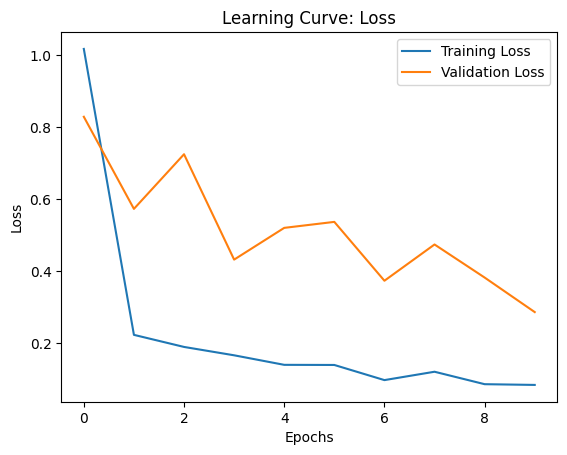

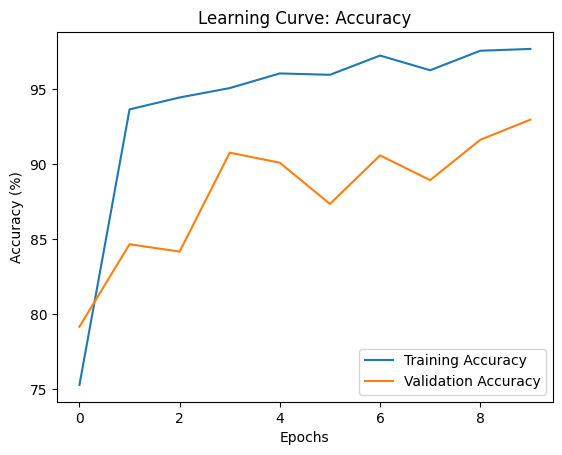

In [37]:
import matplotlib.pyplot as plt

# Train the model
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, criterion, optimizer, train_loader, val_loader, num_epochs=10
)

# Plot losses
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve: Loss')
plt.show()

# Plot accuracies
plt.figure()
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Learning Curve: Accuracy')
plt.show()
